In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pydot
import os
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import copy
import time
from collections import Counter

In [3]:
import scene
import AllegroWrapper
import contact
import motion_planning
import search
import visualizations

In [4]:
meshcat = None
brick_location = None
brick_rotation = None

In [5]:
meshcat, station, simulator, context, brick_location = scene.init_scenario(brick_location=brick_location, brick_rotation=None, meshcat=meshcat)
allegro = AllegroWrapper.AllegroHand(station, context)
simulator.set_target_realtime_rate(1.0)
x0 = allegro.get_state()

INFO:drake:Meshcat listening for connections at http://localhost:7001


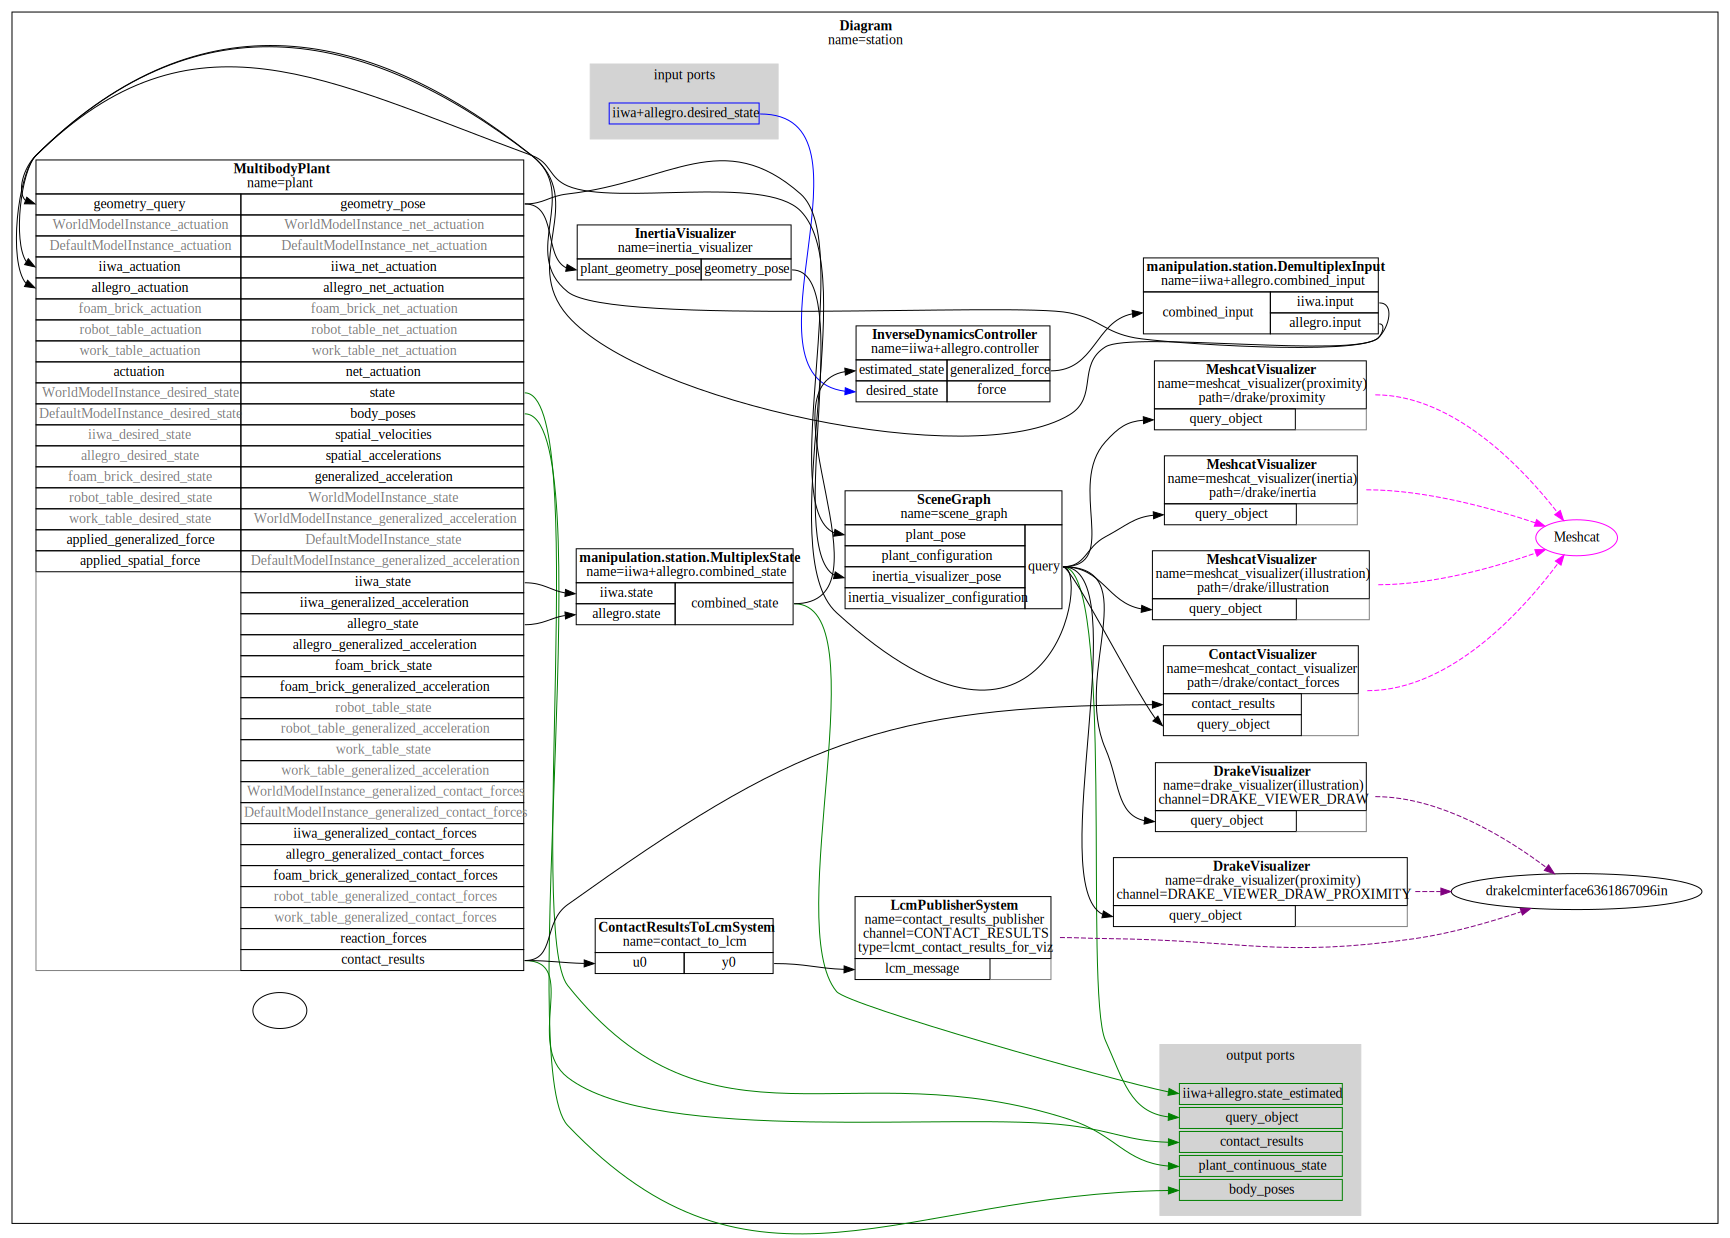

In [6]:
display(
    SVG(
        pydot.graph_from_dot_data(station.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

In [11]:
def reset_arm(station, simulator, context, x0):
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)
    simulator.AdvanceTo(context.get_time() + 1)

In [14]:
brick_location = None
meshcat, station, simulator, context, brick_location, brick_rotation = scene.init_scenario(brick_location=brick_location, meshcat=meshcat)
reset_arm(station, simulator, context, x0)

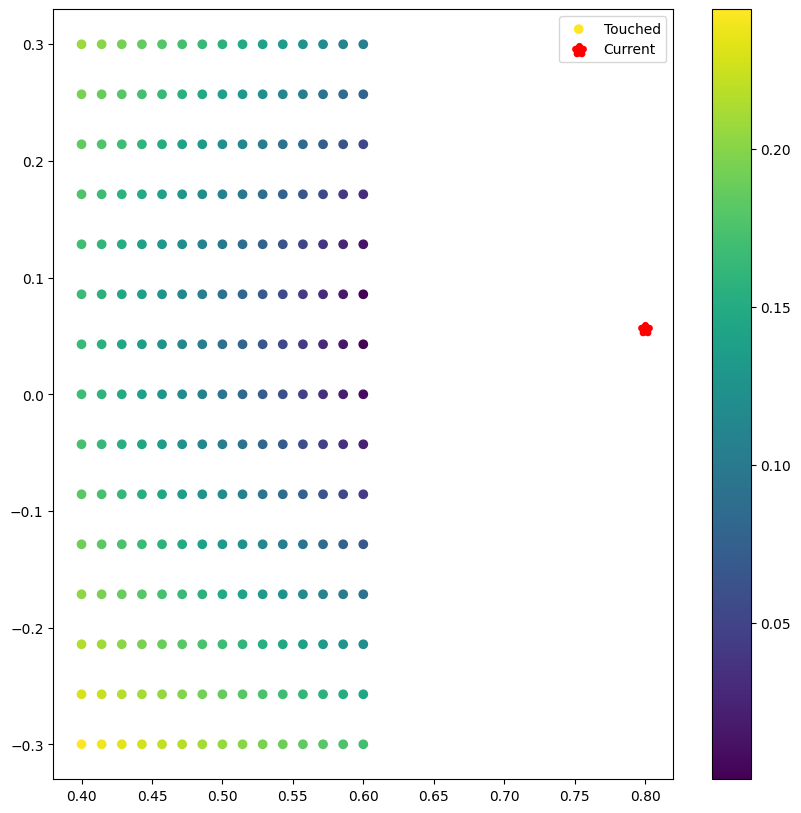

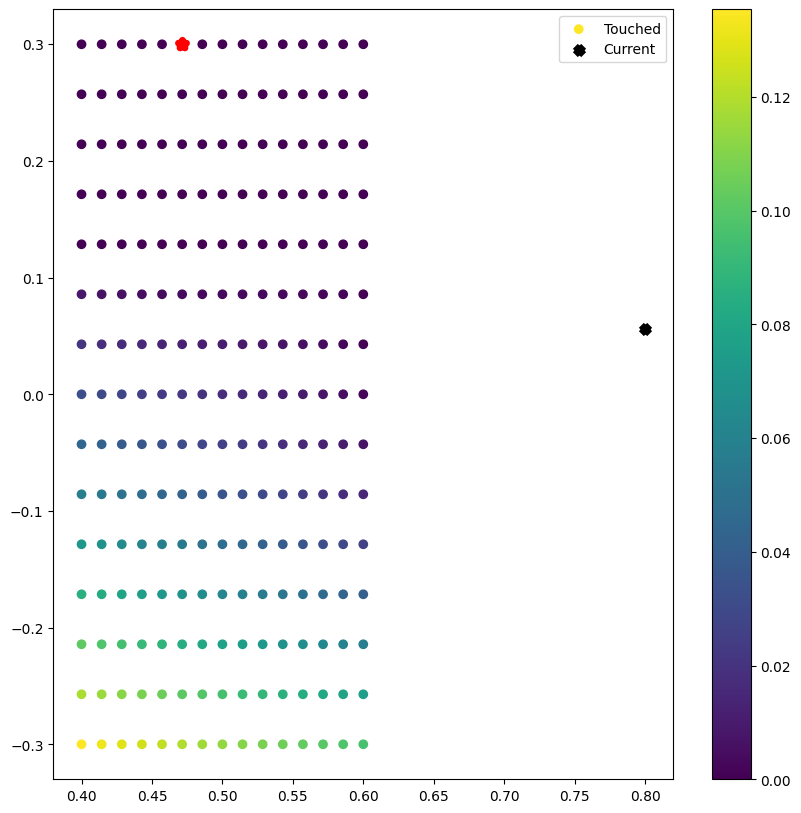

In [15]:
def run_search(station, frame = "iiwa_link_6"):
    plant = station.GetSubsystemByName("plant")
    # Get initial pose of the gripper by using default context of manip station.
    gripper = plant.GetBodyByName(frame)
    plant_context = plant.GetMyContextFromRoot(context)
    X_robot_W = plant.EvalBodyPoseInWorld(plant_context, gripper)
    table_end_effector_poses = contact.get_table_contact(X_robot_W)
    obj_touched, new_contacts = motion_planning.move_arm(simulator, station, context, table_end_effector_poses, time_interval=0.4, frame=frame)

    if obj_touched == "table":
        table_height = new_contacts[0][2]
        touched_point = new_contacts[np.random.choice(np.arange(len(new_contacts)))]
    else:
        print("Table not found")
        # NOTE: Here we should feed coordinates into search algorithm

    p_grid = {}
    all_touched_points = []
    i = 0
    while obj_touched == "table":
        if i > 30:
            break
        i += 1
        # reset_arm()
        current_touch = touched_point[:2]
        all_touched_points.append(current_touch)
        next_touch, p_grid = search.sample_new_target(current_touch, p_grid)
        next_point = [next_touch[0], next_touch[1], table_height]

        # NOTE: This can change if there's biases in the search algorithm, based on the object's height and expected distance from the gripper
        # NOTE: We might also modify it based on some energy constraint, to minimize movement costs
        arc_height = 0.25 
        end_effector_poses = motion_planning.interpolate_locations(touched_point, next_point, X_robot_W, interp_steps=16, arc_height=0.25)
        obj_touched, new_contacts = motion_planning.move_arm(simulator, station, context, end_effector_poses, time_interval=0.4, frame=frame)
        touched_point = copy.deepcopy(next_point)

        x = []
        y = []    
        z = []
        for coord, prob in p_grid.items():
            x.append(coord[0])
            y.append(coord[1])
            z.append(prob)
            
        visualizations.plot_2d_search(all_touched_points, x, y, z)

run_search(station)